In [1]:
import string
from pm4py.objects.process_tree.semantics import ProcessTree
import re
from uuid import uuid4
from pm4py.objects.process_tree.obj import Operator


class TreeNode:
    def __init__(self, name, node_type):
        self.id = uuid4()
        self.name = name
        self.node_type = node_type
        self.children: list[TreeNode] = []

    def __repr__(self):
        return f"{self.name} - {self.children}"


def map_activities_to_letters(activities):
    # List of single letters A-Z
    letters = list(string.ascii_uppercase) + list(string.ascii_lowercase)
    # remove the 'x' letter as it is used for the xor operator
    letters.remove('x')
    letters.remove('a')
    letters.remove('X')

    # Extend with combinations if there are more than 50 activities
    if len(activities) > len(letters):
        combinations = [
            "a".join(pair)
            for pair in zip(
                letters * len(letters),
                letters * (len(activities) // len(letters) + 1),
            )
        ]
        letters.extend(combinations)

    # Create a mapping dictionary
    activity_to_letter = {
        activity: letters[i] for i, activity in enumerate(activities)
    }

    # and the reverse mapping
    letter_to_activity = {v: k for k, v in activity_to_letter.items()}

    return activity_to_letter, letter_to_activity


def parse_tree_str(tree_str):
    # ensure that "->" is recognized correctly as an operator
    match = re.match(r"([+\-*X>]+)\s*\((.*)\)", tree_str.strip())
    
    if not match:
        return TreeNode(name=tree_str.strip(), node_type="activity")

    root_name, children_str = match.groups()

    if root_name not in ["+", "->", "X", "*"]:
        return TreeNode(name=root_name, node_type="activity")

    root = TreeNode(name=root_name, node_type=root_name)

    children_list = []
    start, depth = 0, 0
    for i, c in enumerate(children_str):
        if c == "(":
            depth += 1
        elif c == ")":
            depth -= 1
        elif c == "," and depth == 0:
            children_list.append(children_str[start:i].strip())
            start = i + 1

    children_list.append(children_str[start:].strip())
    for child in children_list:
        root.children.append(parse_tree_str(child))

    return root


def rename_nodes(tree, letter_to_activity, activities):# rename the nodes to the original activity names
    for node in tree.children:
        if node.name in letter_to_activity and node.name not in activities:
            node.name = letter_to_activity[node.name]
        rename_nodes(node, letter_to_activity, activities)
    return tree


def convert_to_pm4py(current: TreeNode, parent: ProcessTree) -> ProcessTree:
    # node
    if current.name == "+":
        operator = Operator.PARALLEL
        label = None
    elif current.name == "->":
        operator = Operator.SEQUENCE
        label = None
    elif current.name == "X":
        operator = Operator.XOR
        label = None
    elif current.name == "*":
        operator = Operator.LOOP
        label = None
    else:
        operator = None
        label = current.name
    tree = ProcessTree(operator=operator, label=label)
    tree.parent = parent
    for child in current.children:        
        tree.children.append(convert_to_pm4py(child, parent=tree))
    return tree


def rename_nodes(tree, letter_to_activity, activities):# rename the nodes to the original activity names
    for node in tree.children:
        if node.name in letter_to_activity and node.name not in activities:
            node.name = letter_to_activity[node.name]
        rename_nodes(node, letter_to_activity, activities)
    return tree


def parse_tree(tree_str: str, activities: set[str]) -> ProcessTree:
    # relace all the activities with single letters
    activity_to_letter, letter_to_activity = map_activities_to_letters(activities)

    # sort activities by length (longest first) to avoid substring issues
    sorted_activities = sorted(activity_to_letter.keys(), key=len, reverse=True)

    # use regex word boundaries (\b) to match whole words
    for activity in sorted_activities:
        letter = activity_to_letter[activity]
        tree_str = re.sub(rf"\b{re.escape(activity)}\b", letter, tree_str)

    # remove quotes
    tree_str = tree_str.replace('"', "")
    tree_str = tree_str.replace("'", "")
    parsed_tree = parse_tree_str(tree_str)    
    # rename the nodes to the original activity names
    parsed_tree = rename_nodes(parsed_tree, letter_to_activity, activities)
    # convert the parsed tree and return a ProcessTree object 
    return convert_to_pm4py(parsed_tree, ProcessTree(operator=None, label="tree"))

In [ ]:
from pm4py.objects.process_tree.obj import Operator

def walk_pm4py_tree(node):
    # Walk the pm4py ProcessTree and collect all operators and activities
    operators = set()
    activities = set()

    def dfs(current_node):
        if current_node is None:
            return
        if current_node.operator is not None:
            # Operator node
            operators.add(current_node.operator.name)
            for child in current_node.children:
                dfs(child)
        elif current_node.label is not None:
            # Activity (leaf)
            activities.add(current_node.label)

    dfs(node)
    return operators, activities

def collect_operator_subtrees(node):
    # Walk a pm4py ProcessTree node and collect (operator, set of activities under it).
    subtrees = []

    def dfs(current_node):
        if current_node is None:
            return set()

        if current_node.operator is not None:
            # operator node
            activities_under = set()
            for child in current_node.children:
                activities_under |= dfs(child)
            subtrees.append((current_node.operator.name, activities_under))
            return activities_under

        elif current_node.label is not None:
            # leaf node (activity)
            return {current_node.label}

        return set()

    dfs(node)
    return subtrees

def match_operator_substitution(true_subtrees, pred_subtrees, threshold=0.8):
    # Match missing operators with extra operators based on activities overlap.
    matches = []
    for true_op, true_acts in true_subtrees:
        for pred_op, pred_acts in pred_subtrees:
            intersection = len(true_acts & pred_acts)
            union = len(true_acts | pred_acts)
            if union == 0:
                continue
            overlap = intersection / union
            if overlap >= threshold:
                matches.append({
                    "true_operator": true_op,
                    "predicted_operator": pred_op,
                    "activities": true_acts,
                    "overlap": overlap
                })
    return matches


def compare_pm4py_trees(true_tree, pred_tree):
    # Compare two pm4py trees and detect missing/extra operators and activities.
    true_operators, true_activities = walk_pm4py_tree(true_tree)
    pred_operators, pred_activities = walk_pm4py_tree(pred_tree)

    missing_operators = true_operators - pred_operators
    extra_operators = pred_operators - true_operators

    missing_activities = true_activities - pred_activities
    extra_activities = pred_activities - true_activities

    return {
        "missing_operators": missing_operators,
        "extra_operators": extra_operators,
        "missing_activities": missing_activities,
        "extra_activities": extra_activities
    }

def detect_true_missing_extra(errors, substitutions):
    # Given errors and substitutions for one sample, return truly missing and extra operators.
    matched_true_operators = set(match["true_operator"] for match in substitutions)
    matched_pred_operators = set(match["predicted_operator"] for match in substitutions)

    true_missing = errors["missing_operators"] - matched_true_operators
    true_extra = errors["extra_operators"] - matched_pred_operators

    return true_missing, true_extra

def count_operators(node):
    counter = {}

    def dfs(current_node):
        if current_node is None:
            return
        if current_node.operator is not None:
            counter[current_node.operator.name] = counter.get(current_node.operator.name, 0) + 1
            for child in current_node.children:
                dfs(child)

    dfs(node)
    return counter

In [ ]:
import pandas as pd
import ast
from tqdm import tqdm 

df = pd.read_csv("") # logs_<>.csv file for pt generation Llama
df["unique_activities"] = df["unique_activities"].apply(ast.literal_eval)

error_records = []
skipped_rows = 0

for idx, row in tqdm(df.iterrows(), total=len(df)):
    try:
        true_tree = parse_tree(row["true_label"], set(row["unique_activities"]))
        pred_tree = parse_tree(row["prediction"], set(row["unique_activities"]))

        errors = compare_pm4py_trees(true_tree, pred_tree)

        if len(errors["extra_activities"]) > 0:
            skipped_rows = skipped_rows + 1
            continue

        true_subtrees = collect_operator_subtrees(true_tree)
        pred_subtrees = collect_operator_subtrees(pred_tree)
        substitutions = match_operator_substitution(true_subtrees, pred_subtrees, threshold=0.7)

        matched_true_operators = set(match["true_operator"] for match in substitutions)
        matched_pred_operators = set(match["predicted_operator"] for match in substitutions)
        true_missing_operators = errors["missing_operators"] - matched_true_operators
        true_extra_operators = errors["extra_operators"] - matched_pred_operators

        true_operator_counts = count_operators(true_tree)
        pred_operator_counts = count_operators(pred_tree)

        error_records.append({
            "id": row["id"],
            "true_label": row["true_label"],
            "prediction": row["prediction"],
            "unique_activities": row["unique_activities"],
            "missing_operators": errors["missing_operators"],
            "extra_operators": errors["extra_operators"],
            "missing_activities": errors["missing_activities"],
            "fitness": row["fitness"],
            "wrong_operator_substitution": substitutions,
            "true_missing_operators": true_missing_operators,
            "true_extra_operators": true_extra_operators,
            "true_operator_counts": true_operator_counts,
            "pred_operator_counts": pred_operator_counts
        })

    except Exception as e:
        print(f"Error processing ID {row['id']}: {e}")
        continue

print(skipped_rows)
error_df = pd.DataFrame(error_records)

100%|██████████| 1524/1524 [00:00<00:00, 2540.48it/s]

253


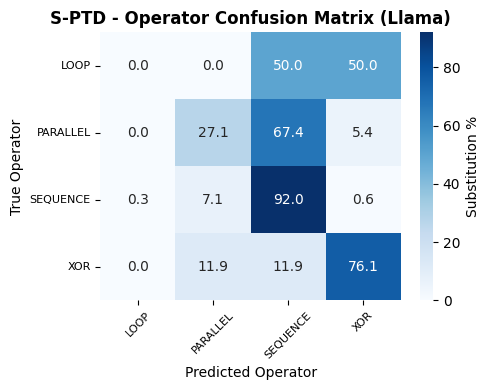

In [ ]:
# plot: S-PTD - Operator Confusion Matrix (Llama)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

substitution_records = []

for idx, row in error_df.iterrows():
    substitutions = row["wrong_operator_substitution"]
    for match in substitutions:
        true_op = match["true_operator"]
        pred_op = match["predicted_operator"]

        substitution_records.append((true_op, pred_op))

substitution_df = pd.DataFrame(substitution_records, columns=["True Operator", "Predicted Operator"])

conf_matrix = substitution_df.pivot_table(
    index="True Operator",
    columns="Predicted Operator",
    aggfunc="size",
    fill_value=0
)

conf_matrix_pct = conf_matrix.div(conf_matrix.sum(axis=1), axis=0) * 100  # Row-wise percentage

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_pct, annot=True, fmt=".1f", cmap="Blues", cbar_kws={'label': 'Substitution %'})
plt.title("S-PTD - Operator Confusion Matrix (Llama)", fontsize=12, weight="bold")
plt.xlabel("Predicted Operator", fontsize=10)
plt.ylabel("True Operator", fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

df_dfg = pd.read_csv("")  # logs_<>.csv file for dfg generation Llama
df_pt = pd.read_csv("")  # logs_<>.csv file for pt generation Llama

domain_df = pd.read_csv("classified_domains.csv") 
df_dfg = df_dfg.merge(domain_df, on="id", how="left")
df_pt = df_pt.merge(domain_df, on="id", how="left")

confidence_threshold = 0.3
df_dfg = df_dfg[df_dfg["confidence_score"] > confidence_threshold]
df_pt = df_pt[df_pt["confidence_score"] > confidence_threshold]

def compute_domain_fitness(df, task_name):
    grouped = df.groupby("domain").agg(
        Fitness=("fitness", "mean"),
        Sample_Count=("fitness", "count")
    ).reset_index()
    grouped["Task"] = task_name
    grouped = grouped.rename(columns={"domain": "Domain", "Sample_Count": "Sample Count"})
    return grouped

dfg_domain_fitness = compute_domain_fitness(df_dfg, "S-DFD")
pt_domain_fitness = compute_domain_fitness(df_pt, "S-PTD")

final_fitness_df = pd.concat([dfg_domain_fitness, pt_domain_fitness], ignore_index=True)

baseline_fitness = {
    "S-DFD": df_dfg["fitness"].mean(),  # overall average
    "S-PTD": df_pt["fitness"].mean()     # overall average
}

/tmp/ipykernel_3315583/2522554042.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_3315583/2522554042.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


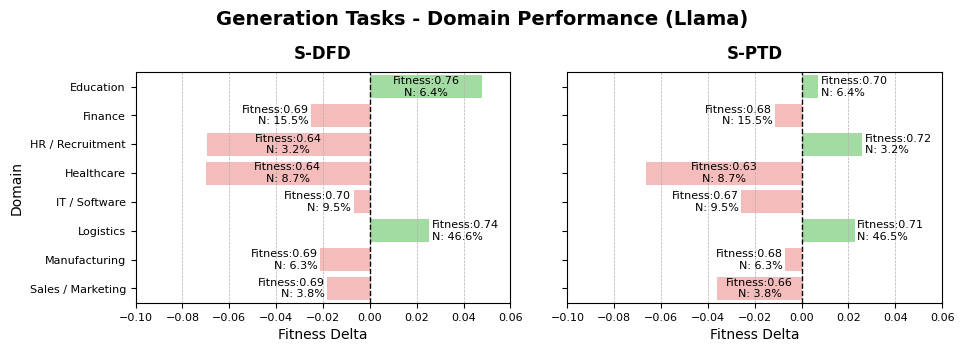

In [ ]:
# plot: Generation Tasks - Domain Performance (Llama)

import matplotlib.pyplot as plt
import seaborn as sns

final_fitness_df["Fitness-Delta"] = final_fitness_df.apply(
    lambda row: row["Fitness"] - baseline_fitness[row["Task"]],
    axis=1
)

tasks = final_fitness_df["Task"].unique()
fig, axes = plt.subplots(1, len(tasks), figsize=(10, 4), sharey=True)

for ax, task in zip(axes, tasks):
    task_df = final_fitness_df[final_fitness_df["Task"] == task].dropna().sort_values("Domain")

    colors = []
    for delta in task_df["Fitness-Delta"]:
        if delta >= 0:
            colors.append((0.6, 0.9, 0.6))  # pastel green
        else:
            colors.append((1.0, 0.7, 0.7))  # pastel red

    sns.barplot(
        data=task_df,
        y="Domain",
        x="Fitness-Delta",
        palette=colors,
        orient="h",
        ax=ax
    )
    
    ax.axvline(0, color='black', linestyle='--', linewidth=1)
    ax.set_xlim(-0.1, 0.06)

    total_samples = task_df["Sample Count"].sum()

    for idx, p in enumerate(ax.patches):
        domain = task_df.iloc[idx]["Domain"]
        fitness = task_df.iloc[idx]["Fitness"]
        sample_count = task_df.iloc[idx]["Sample Count"]

        sample_percentage = (sample_count / total_samples) * 100

        if sample_percentage < 3:
            sample_style = 'oblique'
            sample_color = "blue"
        else:
            sample_style = 'normal'
            sample_color = "black"

        label_text = f"Fitness:{fitness:.2f}\nN: {sample_percentage:.1f}%"

        if abs(p.get_width()) < 0.03:
            ax.annotate(
                label_text,
                (p.get_width() + 0.001 if p.get_width() >= 0 else p.get_width() - 0.001, p.get_y() + p.get_height() / 2),
                ha='left' if p.get_width() > 0 else 'right',
                va='center',
                fontsize=8,
                color=sample_color,
                fontstyle=sample_style
            )
        else:
            ax.annotate(
                label_text,
                (p.get_width() / 2, p.get_y() + p.get_height() / 2),
                ha='center',
                va='center',
                fontsize=8,
                color=sample_color,
                fontstyle=sample_style
            )

    ax.set_title(task, fontsize=12, weight="bold", pad=10)
    ax.set_xlabel("Fitness Delta", fontsize=10)
    ax.set_ylabel("")  # Only leftmost plot has y-label
    ax.grid(axis="x", linestyle="--", linewidth=0.5)
    ax.tick_params(axis='both', labelsize=8)

axes[0].set_ylabel("Domain", fontsize=10)

fig.suptitle("Generation Tasks - Domain Performance (Llama)", fontsize=14, weight="bold", y=0.9)
plt.tight_layout(pad=2)
plt.show()
